## learning-AI : first_step topic 3 
### Linear Regression

<br>

- **임규연 (lky473736)**
- 2025.03.31.에 문서 작성
- **한빛아카데미 "파이토치 첫걸음 (최건호)" 책을 공부 후에 적는 복습용 파일입니다.**
    - 본 파일에는 실습 코드 및 그에 대한 설명, 원리에 대한 정리가 포함되어 있습니다.
- **Reference**
    - https://tutorials.pytorch.kr/beginner/blitz/tensor_tutorial.html
    - https://wikidocs.net/52460
    - https://www.palass.org/publications/newsletter/palaeomath-101/palaeomath-part-4-regression-iv

    
## <span id='dl'><mark>DL</mark></span>
    
선형회귀분석은 특정 데이터셋을 잘 표현할 수 있는 선을 찾는 것이다. 예를 들어서, 우리에게 f(x) = 2x + 1이라고 하는 일차함수가 있다고 가정했을 때, 그에 대하여, 데이터포인트는 기울기 2에 절편 1인 저 직선의 주변에 위치하여 있는 것이다. 결국 데이터의 추세를 잘 파악할 수 있는 직선을 찾는 것이 핵심이다. (물론 입력 변수 X의 사이즈가 1~2개일 때에 직선이 되는 것이지, 3개 이상일 때는 평면 혹은 초평면이 발생한다. 이런 걸 Multiple Linear Regression이라고 부른다.)

<img src="https://www.palass.org/sites/default/files/media/palaeomath_101/article_4/figure_1.jpg" width="500px">

In [148]:
import torch
import torch.nn as nn # 다양한 layer (linear, CNN...)
import torch.optim as optim # optimizer
import torch.nn.init as init

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

---

### Tensor 조작

tensor는 다차원 배열로 n차원의 배열을 전부 포함하는 넓은 개념이다. 하지만 명확히 구분하자면 아래와 같다.

- (N, 1), (1, N) 형태 : vector
- (N, M) 형태 : matrix
- (N, M, !, ...) 형태 : tensor

tensor는 ndarray (numpy 기본 단위) 랑 거의 똑같은 계산 방식 및 manipulation을 가지고 있어서 처리하기 편하다고 한다. 그리고 GPU를 사용할 수 있기 때문에 병렬 연산 측면에서 우세하다

In [149]:
# Tensor 정의
X = torch.Tensor(4, 5)
X # 4 by 5

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [150]:
# Tensor 정의 + 데이터까지
X = torch.Tensor(data=[1, 2, 3, 4, 5, 6])
Y = torch.Tensor(data=[[0, 1, 2], 
                       [4, 5, 6]])
print (X)
print (Y)

X[0] = 100
Y[0][2] = 100

print (X)
print (Y)

tensor([1., 2., 3., 4., 5., 6.])
tensor([[0., 1., 2.],
        [4., 5., 6.]])
tensor([100.,   2.,   3.,   4.,   5.,   6.])
tensor([[  0.,   1., 100.],
        [  4.,   5.,   6.]])


In [151]:
# Tensor의 속성 및 연산 기능
 
print (X.dtype) # 기본이 Float32이라고 함
print (X.sum()) # 모든 complement의 합
print (len(X)) # 몇개의 행이 있나?
print (len(Y))
print (X.data) # data 자체
print (X.device) # CPU == CPU로 연산하겠음

torch.float32
tensor(120.)
6
2
tensor([100.,   2.,   3.,   4.,   5.,   6.])
cpu


In [152]:
'''
requires_grad=True의 의미텐서에 대해 미분 값을 계산하겠다는 뜻입니다.
이 속성이 True이면, 해당 텐서의 모든 연산이 연산 그래프에 기록됩니다.
나중에 backward() 함수를 호출하면, 이 텐서에 대해 **기울기(gradient)**를 계산할 수 있습니다.
== 그러면 나중에 Weight나 bias같은 건 epoch마다의 update가 필요할테니 requires_grad=True가 꼭 필요하겠다
'''

X = torch.tensor(data=[2.0, 3.0],  # 2.0, 3.0이 weight가 아니다. X임
                 requires_grad=True)
print (X)

tensor([2., 3.], requires_grad=True)


In [153]:
'''
1. requires_grad=True가 의미하는 것
requires_grad=True는 해당 텐서에서의 연산이 연산 그래프에 기록된다는 의미입니다. 
즉, 텐서에서 이루어진 연산들을 추적하여 미분 계산을 가능하게 해줍니다. 
이 연산들은 **backward()**를 호출할 때 **기울기(gradient)**를 계산하는 데 사용됩니다.

2. 연산 그래프 (Computation Graph)
텐서 X에 대해 연산이 일어나면, 연산 그래프가 만들어지고, 이를 통해 각 연산의 기울기를 계산할 수 있습니다.

3. loss.backward()의 역할
loss.backward()는 손실 함수(loss)의 미분값을 계산하는 역할을 합니다. 
이때 미분값(기울기)은 **연산 그래프를 따라 역전파(backpropagation)**를 통해 계산됩니다.
'''

'\n1. requires_grad=True가 의미하는 것\nrequires_grad=True는 해당 텐서에서의 연산이 연산 그래프에 기록된다는 의미입니다. \n즉, 텐서에서 이루어진 연산들을 추적하여 미분 계산을 가능하게 해줍니다. \n이 연산들은 **backward()**를 호출할 때 **기울기(gradient)**를 계산하는 데 사용됩니다.\n\n2. 연산 그래프 (Computation Graph)\n텐서 X에 대해 연산이 일어나면, 연산 그래프가 만들어지고, 이를 통해 각 연산의 기울기를 계산할 수 있습니다.\n\n3. loss.backward()의 역할\nloss.backward()는 손실 함수(loss)의 미분값을 계산하는 역할을 합니다. \n이때 미분값(기울기)은 **연산 그래프를 따라 역전파(backpropagation)**를 통해 계산됩니다.\n'

In [154]:
y = X ** 2
z = 2 * y + 3 

target = torch.Tensor([3.0, 4.0])
loss = torch.sum(torch.abs(z-target)) # MAE
loss.backward()

print ("gradient : ", X.grad, y.grad, z.grad)

gradient :  tensor([ 8., 12.]) None None


/var/folders/_z/gryfr07n59jgb3wrd062h1ym0000gn/T/ipykernel_9714/683552945.py:8: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print ("gradient : ", X.grad, y.grad, z.grad)


--- 

### Linear Regression

torch.float32
tensor([-334.9900, -221.9900,   35.0100,  -27.9900,  464.0100,  291.0100,
        -227.9900,  180.0100,  462.0100, -100.9900,  258.0100, -224.9900,
         302.0100, -156.9900,   38.0100,  -59.9900,  510.0100,  424.0100,
         392.0100, -241.9900, -389.9900, -317.9900, -246.9900,  329.0100,
         264.0100, -107.9900,   74.0100,  234.0100, -142.9900,   89.0100,
         432.0100,    7.0100, -369.9900,  247.0100,  413.0100,  127.0100,
         265.0100,   38.0100,    9.0100,  133.0100,   76.0100,  443.0100,
        -344.9900,    5.0100,  121.0100, -322.9900, -286.9900, -351.9900,
         157.0100,  182.0100,   60.0100, -420.9900,  334.0100,  486.0100,
         -91.9900, -119.9900,   36.0100, -376.9900,  440.0100, -161.9900,
         187.0100,  322.0100,  188.0100, -280.9900,  433.0100, -302.9900,
        -417.9900,  443.0100,  507.0100, -145.9900,  401.0100,  349.0100,
         235.0100,  295.0100,  211.0100, -156.9900, -364.9900,  562.0100,
         289.0100,  477.

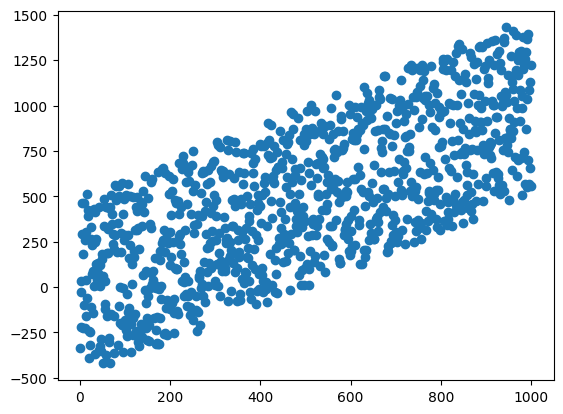

In [155]:
# 데이터 만들기 및 visualization

import random 

num_data = 1000

X = torch.tensor([0.01 + i + random.randrange(-500, 500) for i in range (1, num_data+1)], requires_grad=True)
print (X.dtype)
print (X)

plt.scatter (x=[i for i in range (1, num_data+1)], y=X.detach().numpy())
plt.show()

tensor([[ 3.0003e+00],
        [-1.3883e+00],
        [-5.1684e+00],
        [-1.6643e+00],
        [ 7.4361e+00],
        [ 4.1705e+00],
        [ 4.8784e+00],
        [ 5.3546e+00],
        [ 8.3778e+00],
        [ 8.8379e+00],
        [-1.0769e+00],
        [ 4.2758e+00],
        [-9.1430e-01],
        [-1.5863e+00],
        [ 7.6899e+00],
        [-2.1553e+00],
        [ 9.2767e+00],
        [ 5.0231e-01],
        [-8.9847e+00],
        [-9.5248e+00],
        [-8.4972e+00],
        [-9.1181e+00],
        [-7.7094e+00],
        [ 9.7952e+00],
        [-8.1663e+00],
        [-1.5791e+00],
        [-1.0864e+00],
        [-7.3106e+00],
        [-4.5663e+00],
        [-4.6217e+00],
        [ 1.3501e+00],
        [ 9.7380e+00],
        [ 4.3957e+00],
        [ 6.5682e+00],
        [ 7.1754e+00],
        [-1.2422e+00],
        [ 1.0191e+00],
        [-6.7898e+00],
        [ 8.7482e+00],
        [ 9.7268e+00],
        [ 3.0372e+00],
        [-6.2282e-01],
        [ 6.3755e+00],
        [ 8

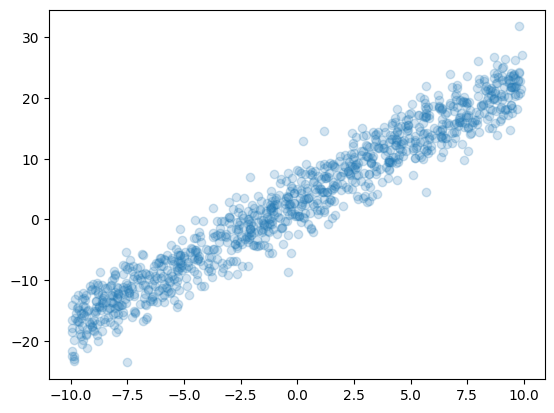

In [156]:
'''
    위와 같이 복잡하게 하지말고, 아래와 같이 데이터 생성 가능
'''

X = init.uniform_(torch.Tensor(num_data, 1), -10, 10) 
# <-- (num_data, 1) 크기의 텐서를 생성하는데 이걸 init_uniform()이라는 걸로 균등하게 초기화 (-10 ~ 10까지 균등하게)
# -10 ~ 10까지 랜덤하게 생성됨
 
noise = init.normal_(torch.FloatTensor(num_data, 1), std=3)  # 노이즈 추가 위함 (현실적으로)
# 가우시안 노이즈

y = 2 * X + 3 # 이 수식을 통해 -17 ~ 23으로 변경
y_noise = y + noise

print (X, y_noise)

plt.scatter(X, y_noise, alpha=0.2)
plt.show()

In [157]:
model = nn.Linear(1, 1) # <-- 선형회귀 모델
# X = 1개의 특성을 가진 데이터 1000개임
# y = 1개의 특성을 가진 데이터 1000개임
# 1, 1

loss_func = nn.L1Loss() # <-- MAE (L1 loss) vs MSE (L2 loss)

optimizer = optim.SGD (model.parameters(), lr=0.001) # SGD (확률적 경사하강법)
# 여기서 model.parameters는 w와 b일 것이다. 
# lr는 learning rate

  0%|          | 0/1000 [00:00<?, ?it/s]

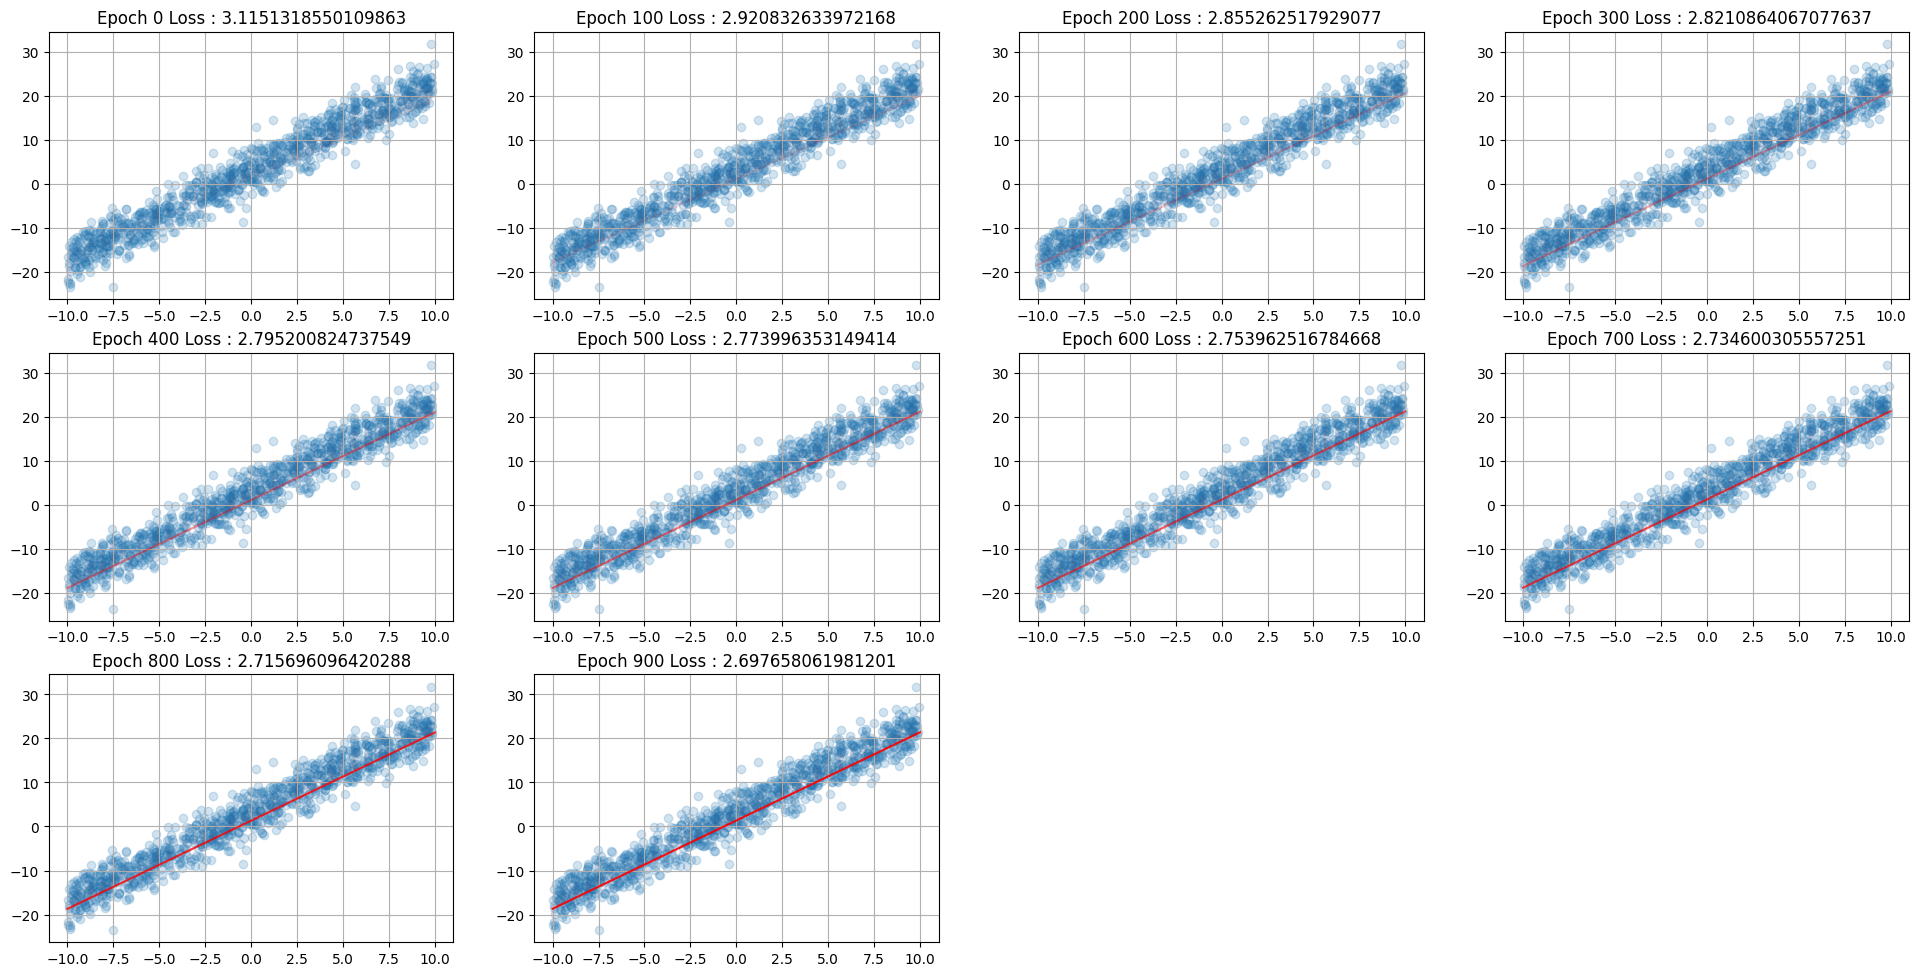

In [159]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

num_epoch = 1000
label = y_noise
loss_lst = []

# 새로운 시각화를 위한 큰 figure 사이즈
fig = plt.figure(figsize=(24, 16))

for n in tqdm(range(num_epoch)):
    optimizer.zero_grad()  # 기울기를 0으로 초기화
    output = model(X)  # 모델에 X를 넣는다
    
    loss = loss_func(output, label)  # L1 오차함수에 모델 결과랑 label을 넣어서 오차를 만든다
    loss.backward()  # 그 오차 가지고 역전파
    optimizer.step()  # 변수들의 기울기 업데이트
    
    if n % 100 == 0:
        # 서브플롯 4열로 분배, 4열씩 그리도록 수정
        plt.subplot(4, 4, n//100 + 1)  # 4열로 배치
        plt.scatter(X, y_noise, alpha=0.2)
        
        # 모델을 통한 예측 값 시각화 (red line)
        plt.plot([-10, 10], model(torch.Tensor([[-10], [10]]))
                 .squeeze().detach().numpy(), color='r', alpha=(n / num_epoch))
        
        # 예측 값과 실제 값의 차이를 나타내는 수직선
        for i in range(num_data):
            y_true = y_noise[i].item()
            y_pred = model(torch.Tensor([X[i]])).detach().numpy()
            plt.vlines(X[i], min(y_true, y_pred), max(y_true, y_pred), color='red', alpha=0.01)
        
        # 타이틀에 epoch과 loss 표시
        plt.title(f"Epoch {n} Loss : {loss.item()}")
        plt.grid(True)

    loss_lst.append(loss.data.item())

# 그래프 최종 출력
plt.show()


In [160]:
param_list = list(model.parameters())
print(param_list[0].item(), param_list[1].item()) # 첫번째가 weight, 두번째가 bias

2.006469488143921 1.3983943462371826


--- 

### 파이토치와 sklearn, normal equation의 각각의 gradient 비교

In [161]:
X_np = X.detach().numpy() # detach == computational graph에서 숫자들 다 떼와서 넘파이로 바꾼다
y_noise_np = y_noise.detach().numpy()

print(X_np.shape, y_noise_np.shape )

(1000, 1) (1000, 1)


In [162]:
# sklearn

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_np, y_noise_np)
print (model.coef_, model.intercept_)

[[2.0238805]] [2.9459236]


#### normal equation

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSAQ2PTUJmJwWdl6wKo7e8spJ0EqFXK2L0mJkqeuGwp5tjrMLULZXnplFPh5FT6HfSlOyQ&usqp=CAU" width="300px">

In [167]:
# normal equation

X_mean = X_np.mean()
y_mean = y_noise_np.mean()
print (X_mean, y_mean)

b = np.sum((X_np - X_mean) * (y_noise_np - y_mean)) / np.sum((X_np - X_mean)**2)
a = y_mean - b * X_mean

print (b, a)

-0.04380594 2.8572655
2.0238805 2.9459236
